In [1]:
import cobra
import pandas as pd
import os
from os.path import join 
from cobra import Model, Reaction, Metabolite
from cobra.sampling import sampling 
import numpy as np
os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
import rpy2.robjects 
from plotnine import *
import matplotlib.pyplot as plt

In [14]:
# Importing the model
model1=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\iRhto_models\\iRhtoC.xml")
model1.objective = "BIOMASS_RT_CLIM"  


In [15]:
# Lab data
glucose_uptakes = [0.476, 1.114, 1.648, 2.305, 3.1] 
# growth_rates = [0.049, 0.100, 0.151, 0.203, 0.25, 0.301]

solution1 = model1.optimize()
# All fluxes
all_fluxes = solution1.fluxes.to_frame(name='Flux')
all_fluxes

,Flux
RLFC2O_c,0.000000
RLFC2O_m,0.000000
BTDDH_c,0.000000
LLFC2O_c,0.000000
13GS_c,0.380252
...,...
ECOAI82e_x,0.000000
DECOAI82e_x,0.000000
DECOAR82e_x,0.000000
ECOAI81e_x,0.000000


In [16]:
# Get all fluxes on different glucose uptake
all_fluxes_biomass_max = pd.DataFrame(columns=['Glucose uptake', 'Grpwth rate', *all_fluxes.index], index=range(len(glucose_uptakes))) #flux_values.index gives the row names column, * extracts the list of strings

for i in range(len(glucose_uptakes)):
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\iRhto_models\\iRhtoC.xml")
    model.objective = "BIOMASS_RT_CLIM"  
    model.reactions.EX_glc__D_e.bounds = -(glucose_uptakes[i]), -(glucose_uptakes[i])
    # model.reactions.BIOMASS_RT_CLIM.bounds = growth_rates[i], growth_rates[i]
    
    solution = model.optimize()
    
    all_fluxes_biomass_max.loc[i] = solution.fluxes[['EX_glc__D_e', 'BIOMASS_RT_CLIM', *all_fluxes.index]].values

all_fluxes_biomass_max

: 

In [ ]:
# Get specific metabolites with their fluxes
exchange_fluxes_table = all_fluxes_biomass_max[['EX_glc__D_e', 'EX_o2_e', 'EX_nh4_e','EX_so4_e','EX_pi_e', 'EX_co2_e']]

for i in range(len(exchange_fluxes_table.columns)):
    exchange_fluxes_table = exchange_fluxes_table.rename(columns = {exchange_fluxes_table.columns[i]: getattr(model.reactions, exchange_fluxes_table.columns[i]).name})

exchange_fluxes_table

,D-glucose exchange,oxygen exchange,ammonium exchange,sulphate exchange,phosphate exchange,carbon dioxide exchange
0,-0.476,-1.299965,-0.21939,-0.00279,-0.018291,1.436344
1,-1.114,-2.893941,-0.534371,-0.006796,-0.044552,3.226121
2,-1.648,-4.228085,-0.798007,-0.010149,-0.066533,4.724148
3,-2.305,-5.86953,-1.122368,-0.014274,-0.093576,6.567226
4,-3.1,-7.855755,-1.51486,-0.019265,-0.126299,8.797435


In [ ]:
intracellular_fluxes = all_fluxes_biomass_max[['ATPM_c', 'EX_glc__D_e', 'G6PDH2i_c', 'TKT1_c', 'TALA_c','TKT2_c', 'PKETF_c', 'FBA_c',  'PYRDC_c','PDH_m', 'ACITL_c']] #doesn't have 'XPK' (Xylulose-5-phosphate phosphoketolase), it has only 'FPK' (Fructose-6-phosphate phosphoketolase)
# Change column IDs to names
for i in range(len(intracellular_fluxes.columns)):
    intracellular_fluxes = intracellular_fluxes.rename(columns = {intracellular_fluxes.columns[i]: getattr(model.reactions, intracellular_fluxes.columns[i]).name})

intracellular_fluxes = intracellular_fluxes.rename(columns = {'glucose 6-phosphate dehydrogenase': 'oxPPP', 'ATP maintenance requirement': 'NGAM'})
intracellular_fluxes

,NGAM,D-glucose exchange,oxPPP,transketolase 1,transaldolase,transketolase 2,phosphoketolase (fructose 6-phosphate),fructose-bisphosphate aldolase,pyruvate decarboxylase,pyruvate dehydrogenase,ATP citrate lyase
0,1.189,-0.476,0.244966,0.080545,-0.242963,0.07198,0.0,0.0,0.0,0.53112,0.187384
1,1.189,-1.114,0.596667,0.196186,0.196186,0.175322,0.0,0.742574,0.0,1.202857,0.456413
2,1.189,-1.648,0.891037,0.292975,-0.800353,0.261819,0.0,0.0,0.0,1.765094,0.681589
3,1.189,-2.305,1.253212,0.41206,-1.112814,0.368239,0.0,0.0,0.0,2.456835,0.95863
4,1.189,-3.1,1.69146,0.556157,-1.490907,0.497012,0.0,0.0,0.0,3.293873,1.293863


Text(0, 0.5, 'Flux $(g/gDW/h)$')

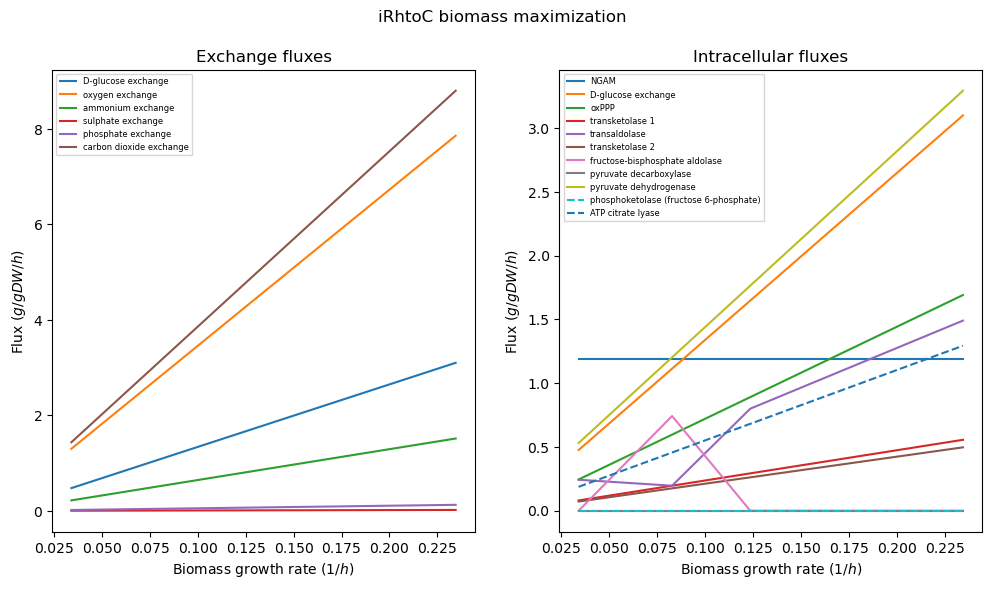

In [ ]:
# Plot exchange and intracellular fluxes
fig, ax = plt.subplots(1, 2, figsize=(12,6)) #, 
fig.suptitle('iRhtoC biomass maximization')

# Sample data

x1 = all_fluxes_biomass_max['BIOMASS_RT_CLIM']
y1 = np.abs(exchange_fluxes_table)

ax[0].plot(x1, y1, '-', label= y1.columns) #
ax[0].legend(fontsize=6, loc='upper left')
ax[0].set_title("Exchange fluxes") #fluxes biomass maximization
ax[0].set_xlabel('Biomass growth rate $(1/h)$')
ax[0].set_ylabel('Flux $(g/gDW/h)$')

x2 = all_fluxes_biomass_max['BIOMASS_RT_CLIM']
y2 = np.abs(intracellular_fluxes.drop(columns = ['phosphoketolase (fructose 6-phosphate)','ATP citrate lyase']))
y3 = np.abs(intracellular_fluxes[['phosphoketolase (fructose 6-phosphate)','ATP citrate lyase']])

ax[1].plot(x2, y2, '-', label= y2.columns) #
ax[1].plot(x2, y3, '--', label= y3.columns) # ACL and phosphoketolase

ax[1].legend(fontsize=6, loc='upper left')
ax[1].set_title("Intracellular fluxes")
ax[1].set_xlabel('Biomass growth rate $(1/h)$')
ax[1].set_ylabel('Flux $(g/gDW/h)$')

COFACTOR BALANCES 

In [2]:
glucose_uptakes = [0.476, 1.114, 1.648, 2.305, 3.1] 
# Cofactor lists
nadphs = ['nadph_c', 'nadph_l', 'nadph_m', 'nadph_r', 'nadph_rm','nadph_x']
nadhs = ['nadh_c', 'nadh_m', 'nadh_x', 'nadh_r', 'nadh_rm']
atps = ['atp_c', 'atp_m', 'atp_n', 'atp_r', 'atp_en', 'atp_gm', 'atp_l', 'atp_rm', 'atp_vm', 'atp_x'] 

# Make a function for getting cofactor fluxes (all reactions where given metabolite is and their fluxes)

def cofactor_all_rxn_fluxes(cofactor_list, i):
    producing_fluxes = pd.DataFrame() 
    consuming_fluxes = pd.DataFrame()
    
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\iRhto_models\\iRhtoC.xml")
    
    model.reactions.EX_glc__D_e.bounds = -(glucose_uptakes[i]), -(glucose_uptakes[i])
    model.objective = "BIOMASS_RT_CLIM"
    solution = model.optimize()

    for metabolite in cofactor_list:
        producing_fluxes = pd.concat([producing_fluxes, getattr(model.metabolites, metabolite).summary().producing_flux])
        consuming_fluxes = pd.concat([consuming_fluxes, getattr(model.metabolites, metabolite).summary().consuming_flux])
    
    for reaction in producing_fluxes.index:
        if reaction in consuming_fluxes.index and abs(round(producing_fluxes.loc[reaction, 'flux'], 3)) == abs(round(consuming_fluxes.loc[reaction, 'flux'], 3)):
            producing_fluxes = producing_fluxes.drop([reaction])
            consuming_fluxes = consuming_fluxes.drop([reaction])
            
    cofactor_fluxes = pd.concat([producing_fluxes, consuming_fluxes])

    cofactor_fluxes = cofactor_fluxes.sort_values(by='flux', ascending=False).drop(columns = ['percent']) # drop percent column, bc these percents are not for nadph sum (the percent is for specific compartment)
    cofactor_fluxes = cofactor_fluxes[(cofactor_fluxes['flux']) != 0.0] # for getting non-zero fluxes only

    cofactor_sum_producing_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] > 0]['flux']) # for getting the sum of producing fluxes
    cofactor_sum_consuming_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] < 0]['flux']) # for getting the sum of consumed fluxes
    print(f'SUM produced: {cofactor_sum_producing_flux}, SUM consumed: {cofactor_sum_consuming_flux}')

    if round(cofactor_sum_producing_flux, 3) == round(abs(cofactor_sum_consuming_flux), 3):
        cofactor_fluxes['percent'] = abs(cofactor_fluxes['flux']/cofactor_sum_producing_flux) # add percent column

    return cofactor_fluxes

# Making a pie chart
def cofactor_fluxes_pie_chart(cofactor_fluxes,  title): 
    threshold = 0.05 # threshold shows the percent of the flux for including in others sector on pie chart 
    # The three lines below are for grouping together reactions with low fluxes in producing
    producing_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] > 0).copy()]    
    producing_cofactor_fluxes_draw.loc[producing_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other producing'
    producing_cofactor_fluxes_draw = producing_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()        
    
    # The three lines below are for grouping together reactions with low fluxes in consuming 
    consuming_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] < 0).copy()]
    consuming_cofactor_fluxes_draw.loc[consuming_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other consuming'
    consuming_cofactor_fluxes_draw = consuming_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()
    
    # y_producing = producing_cofactor_fluxes_draw['percent']
    # labels_producing = producing_cofactor_fluxes_draw[['reaction', 'flux']] 
    
    # y_consuming = abs(consuming_cofactor_fluxes_draw['percent'])
    # labels_consuming = consuming_cofactor_fluxes_draw[['reaction', 'flux']]
    
    producing_and_consuming_fluxes = pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])
    
    # reaction_IDs = pd.concat([labels_producing, labels_consuming])
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\iRhto_models\\iRhtoC.xml")
    model.objective = "BIOMASS_RT_CLIM"
    solution = model.optimize()  
    
    reaction_names_w_flux = []
    for reaction in producing_and_consuming_fluxes.index:
        if reaction != 'Other producing' and reaction != 'Other consuming':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), getattr(model.reactions, reaction).name, ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])]
        elif reaction == 'Other producing':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), 'Other producing', ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])] 
        elif reaction == 'Other consuming':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), 'Other consuming', ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])] 
    
    fig = plt.figure()
    pie_chart = plt.pie(producing_and_consuming_fluxes.loc[:, 'percent'], labels = reaction_names_w_flux)  #autopct='%1.1f%%' pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])[['flux', 'percent']]
    # plt.legend(producing_and_consuming_fluxes, reaction_names_w_flux, title = 'Reaction names', loc="center left",  bbox_to_anchor=(1, 0, 0.5, 1))
    # plt.title(title)
    
    return pie_chart, fig


In [5]:
# Get nadph fluxes at lowest biomass growth rate

nadph_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadphs, 0)
nadph_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

nadph_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadphs, 4)
nadph_fluxes_highest_GR

# Get nadh fluxes at lowest biomass growth rate

nadh_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadhs, 0)
nadh_fluxes_lowest_GR

# Get nadh fluxes at highest biomass growth rate

nadh_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadhs, 4)
nadh_fluxes_highest_GR

# Get atp fluxes at lowest biomass growth rate

atp_fluxes_lowest_GR = cofactor_all_rxn_fluxes(atps, 0)
atp_fluxes_lowest_GR

# Get atp fluxes at highest biomass growth rate

atp_fluxes_highest_GR = cofactor_all_rxn_fluxes(atps, 4)
atp_fluxes_highest_GR

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-21
SUM produced: 0.546344166103363, SUM consumed: -0.546344166092697
SUM produced: 3.7724448958925714, SUM consumed: -3.7724448957801715


,flux,reaction,percent
G6PDH2i_c,1.691460,G6PDH2i_c,0.448372
GND_c,1.691460,GND_c,0.448372
ME2_m,0.242928,ME2_m,0.064395
MTHFD_c,0.074771,MTHFD_c,0.019820
MTHFD_m,0.028934,MTHFD_m,0.007670
...,...,...,...
AGPRi_m,-0.074956,AGPRi_m,0.019869
ASAD_c,-0.116897,ASAD_c,0.030987
KARA1i_m,-0.142283,KARA1i_m,0.037716
HMGCOAR_c,-0.419783,HMGCOAR_c,0.111276


In [ ]:
# import pickle

# with open("../cofactor_comparison/iRhtoC_cofactors.pk", "wb") as f:
#     pickle.dump([nadph_fluxes_lowest_GR, nadph_fluxes_highest_GR, nadh_fluxes_lowest_GR, nadh_fluxes_highest_GR, atp_fluxes_lowest_GR, atp_fluxes_highest_GR], f)

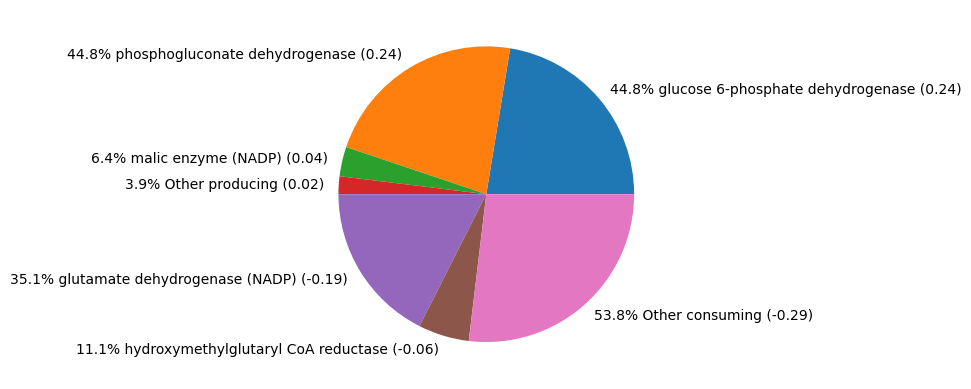

In [6]:
# Make a pie plot for napdh
# threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'iRhtoC NADPH producing and conusming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_nadph_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title)
producing_nadph_fluxes_lowest_GR_pie_chart

fig.savefig("..\\..\\Thesis_paper_latex\\Pictures\\iRhtoC_bm_NADPH_min.png")

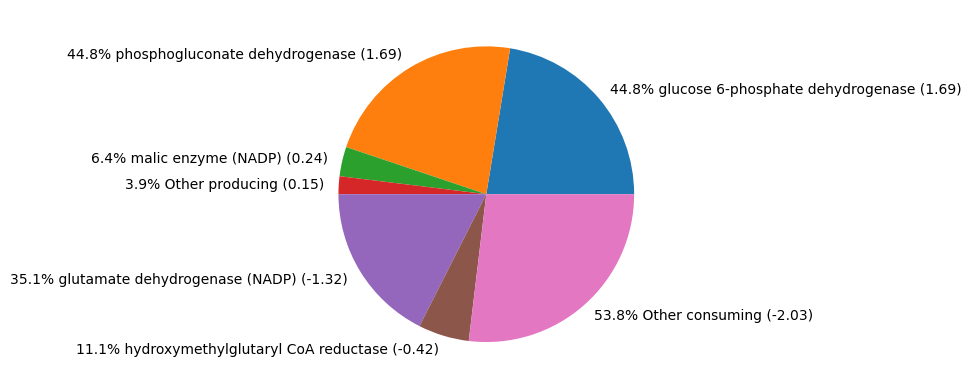

In [7]:
# Make a pie plot for napdh
# threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'iRhtoC NADPH producing and conusming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_nadph_fluxes_highest_GR_pie_chart, fig  = cofactor_fluxes_pie_chart(nadph_fluxes_highest_GR, title)
producing_nadph_fluxes_highest_GR_pie_chart

fig.savefig("..\\..\\Thesis_paper_latex\\Pictures\\iRhtoC_bm_NADPH_max.png")

([<matplotlib.patches.Wedge at 0x24f902e43b0>,
 [Text(1.0234238771430588, 0.40324132686701303, '23.9% glyceraldehyde-3-phosphate dehydrogenase (0.72)'),
  Text(0.6784315038456632, 0.8658699062732877, '9.9% glycine-cleavage complex (lipoamide) (0.3)'),
  Text(0.35891862517985706, 1.039796816930597, '11.3% isocitrate dehydrogenase (NAD+) (0.34)'),
  Text(-0.4041344058901261, 1.0230715429410766, '33.9% malate dehydrogenase (1.01)'),
  Text(-0.9017986633042695, 0.6298882209270411, '3.4% Other producing (0.1)'),
  Text(-1.05766451103016, 0.30223464743032485, '17.7% pyruvate dehydrogenase (0.53)'),
  Text(-1.014550072163293, -0.4250742888877863, '25.3% malate dehydrogenase (-0.76)'),
  Text(0.40906296361991873, -1.0211109106235665, '73.7% NADH:ubiquinone oxidoreductase (complex I) (-2.21)'),
  Text(1.0998639065803681, -0.017302803292280844, '1.0% Other consuming (-0.03)')])

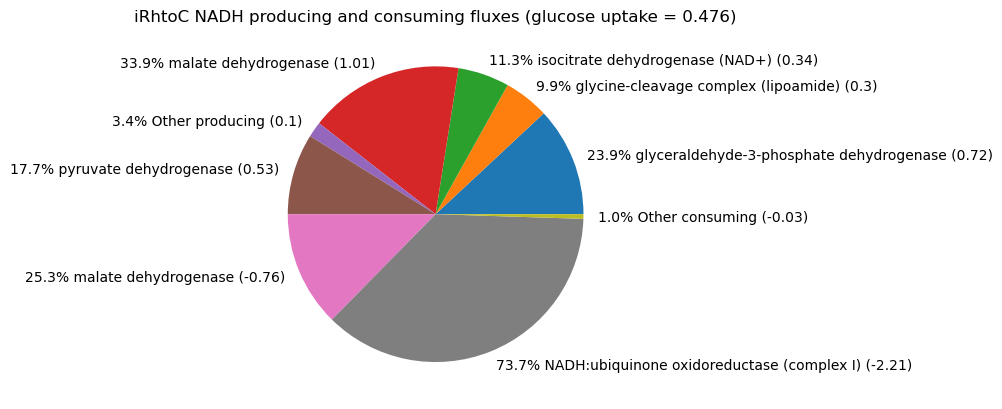

In [ ]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'iRhtoC NADH producing and consuming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_nadh_fluxes_lowest_GR_pie_chart, fig  = cofactor_fluxes_pie_chart(nadh_fluxes_lowest_GR, title, threshold)
producing_nadh_fluxes_lowest_GR_pie_chart

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


([<matplotlib.patches.Wedge at 0x24f9b4a8bc0>,
 [Text(1.0177684489518604, 0.41730969832742293, '24.8% glyceraldehyde-3-phosphate dehydrogenase (4.57)'),
  Text(0.6656615851687623, 0.8757252160527358, '9.1% glycine-cleavage complex (lipoamide) (1.68)'),
  Text(0.36781505628219663, 1.0366832131235293, '10.6% isocitrate dehydrogenase (NAD+) (1.96)'),
  Text(-0.3857628604154346, 1.0301393185021637, '33.9% malate dehydrogenase (6.26)'),
  Text(-0.8951645423973892, 0.6392811916789614, '3.8% Other producing (0.7)'),
  Text(-1.057055480882569, 0.3043578655729484, '17.8% pyruvate dehydrogenase (3.29)'),
  Text(-1.0074491358132271, -0.4416403952869144, '26.3% malate dehydrogenase (-4.85)'),
  Text(0.4238008402834575, -1.0150826802655217, '72.6% NADH:ubiquinone oxidoreductase (complex I) (-13.39)'),
  Text(1.0998288556074234, -0.019403308307235204, '1.1% Other consuming (-0.21)')])

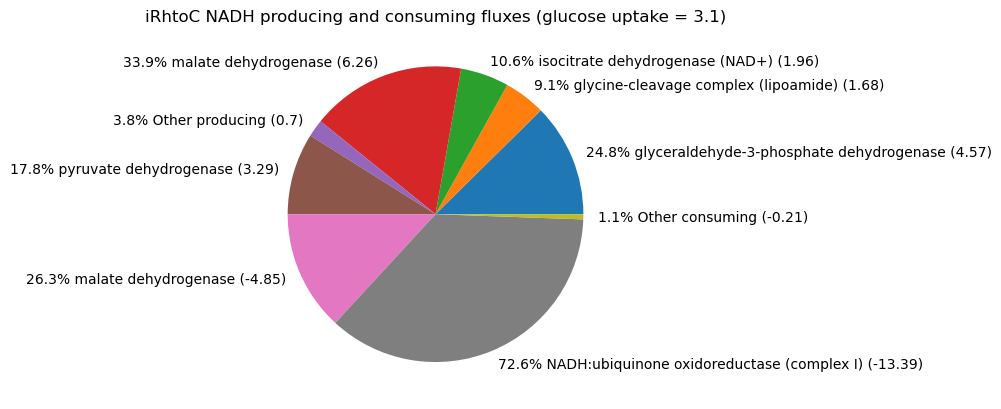

In [ ]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'iRhtoC NADH producing and consuming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_nadh_fluxes_highest_GR_pie_chart, fig  = cofactor_fluxes_pie_chart(nadh_fluxes_highest_GR, title, threshold)
producing_nadh_fluxes_highest_GR_pie_chart

([<matplotlib.patches.Wedge at 0x24f9f04f440>,
 [Text(0.32441607985237475, 1.0510728838349974, '80.9% ATP synthase (7.14)'),
  Text(-0.9091063096315409, 0.6192945323415355, '0.0% Other producing (0.0)'),
  Text(-0.9808541476987928, 0.49792081794405324, '8.1% phosphoglycerate kinase (0.72)'),
  Text(-1.0726329793143317, 0.24384111976297407, '7.6% pyruvate kinase (0.67)'),
  Text(-1.0984890689876554, 0.05763475786913941, '3.3% succinate-CoA ligase (ADP-forming) (0.29)'),
  Text(-1.099387849928347, -0.0366927163061937, '2.1% ATP citrate lyase (-0.19)'),
  Text(-1.0945932253114103, -0.10892966126067075, '2.1% adenylate kinase (-0.18)'),
  Text(-1.0357950186959362, -0.37030889706390485, '13.5% ATP maintenance requirement (-1.19)'),
  Text(-0.007815715896563874, -1.0999722335518403, '64.2% Biomass_Rt_Clim (-5.67)'),
  Text(0.9733939233124079, -0.512351705431414, '5.4% hexokinase (D-glucose:ATP) (-0.48)'),
  Text(1.0676459195561125, -0.26482482975578975, '10.0% Other consuming (-0.88)'),
  Te

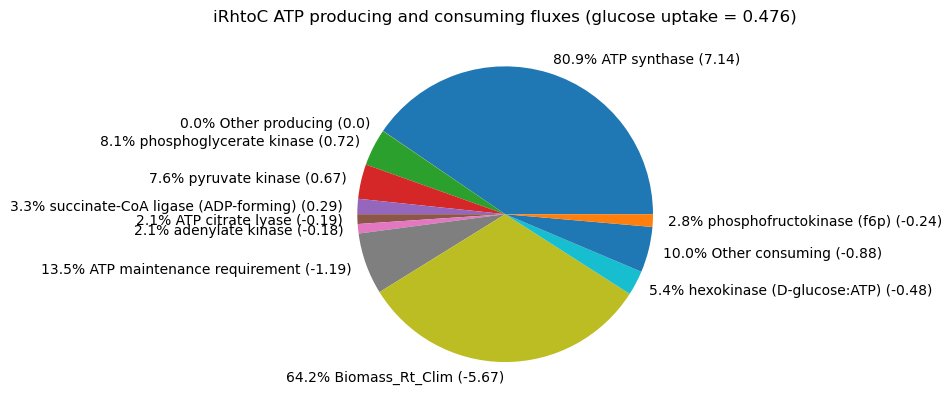

In [ ]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'iRhtoC ATP producing and consuming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_atp_fluxes_lowest_GR_pie_chart, fig  = cofactor_fluxes_pie_chart(atp_fluxes_lowest_GR, title,  threshold)
producing_atp_fluxes_lowest_GR_pie_chart

([<matplotlib.patches.Wedge at 0x24f944beb70>,
 [Text(0.33331668051412966, 1.0482843080438826, '80.4% ATP synthase (43.03)'),
  Text(-0.8985391197022976, 0.6345293140309755, '0.1% Other producing (0.03)'),
  Text(-0.9757774661706823, 0.5077975349620392, '8.5% phosphoglycerate kinase (4.57)'),
  Text(-1.0731182586044732, 0.24169651021415972, '7.9% pyruvate kinase (4.23)'),
  Text(-1.0986957759029623, 0.05354990208196235, '3.1% succinate-CoA ligase (ADP-forming) (1.66)'),
  Text(-1.099207046329948, -0.04175966114077034, '2.4% ATP citrate lyase (-1.29)'),
  Text(-1.0929977984836714, -0.1239185720941285, '2.4% adenylate kinase (-1.26)'),
  Text(-1.081283294624599, -0.2020555289166151, '2.2% ATP maintenance requirement (-1.19)'),
  Text(-0.22196027842968646, -1.0773734889997137, '73.1% Biomass_Rt_Clim (-39.12)'),
  Text(0.9462922553885685, -0.5608306048992123, '5.8% hexokinase (D-glucose:ATP) (-3.1)'),
  Text(1.061379999671041, -0.2889160713741989, '11.3% Other consuming (-6.07)'),
  Text(1

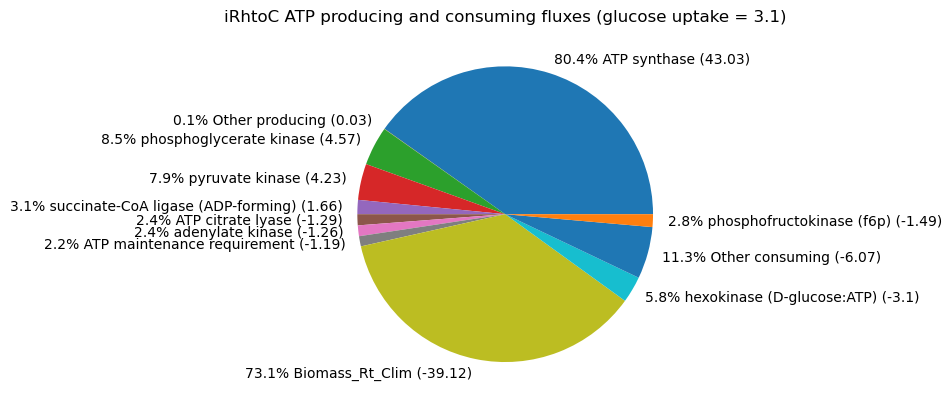

In [ ]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'iRhtoC ATP producing and consuming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_atp_fluxes_highest_GR_pie_chart, fig  = cofactor_fluxes_pie_chart(atp_fluxes_highest_GR, title,  threshold)
producing_atp_fluxes_highest_GR_pie_chart

In [ ]:
# # Get all fluxes to excel
# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\iRhto_results\\iRhto_all_fluxes_glc_max.xlsx') as excel_writer:
#     all_fluxes_glc_max.to_excel(excel_writer, sheet_name='Growth rates 0.05-0.3', index=True)

In [ ]:
# #  Get all flux values separately for dif growth rates, make them to a csv file
# for i in range(len(glucose_uptakes)):
#     all_fluxes_dif_glucose_uptakes.loc[i].to_csv(f'C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\iRhto_results\\iRhto_csv\\iRhto_flux_values_glucose_uptake_{glucose_uptakes[i]}.csv', index=True)

In [ ]:
# #Calculating the missing glucose uptake form lab data, when growth rate is 0.25
# growth_rates = np.array([0.049, 0.100, 0.151, 0.203, 0.25, 0.301]) 
# glucose_uptakes= np.array([-0.476, -1.114, -1.648, -2.305, -2.6619851, -3.1])

# Getting the missing glucose uptake when GR is 0.25
# from sklearn.linear_model import LinearRegression
# lm = LinearRegression()
# lm.fit(growth_rates[:, None], glucose_uptakes)

# y = lm.coef_ * 0.25 + lm.intercept_
# y